# Neural Networks (part 1)

## 1. Introduction 
Start by watching the following youtube video from 3blue1brown for a nice introduction in the concepts of neural networks (NN). The example that is used in the video is about handwriting digits classification. You will build a neural network that does exactly that.

The link to the video: https://www.youtube.com/watch?v=aircAruvnKk

Refer to the lecture notes on Canvas for the mathematical description of the network. In this notebook we will use the same names and conventions as used in the lecture notes.

## 2. Loading the data

In this notebook you will use a NN to classify the dataset `NNdata1.txt`. It contains the scores of $M$ students, their scores on two separte tests, and the label (0/1) wether they passed the course or not.

**Notebook aim:** Build a NN model to predict wether a student will pass or not based on the two inputs of the two test scores.

In [1]:
# importing the required modules
import numpy as np
import matplotlib.pyplot as plt

# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

In [2]:
# load the data
FILENAME = './NNdata1.txt'  
DELIMITER = ',' 

data = np.loadtxt(FILENAME, delimiter=DELIMITER)

## 3. Create the feature matrix X and labels matrix Y

The data that is fed into the NN constist of column vectors $\textbf x_i$ containing the features of the sample $i$. Because usually many samples are required to train and test the NN it is computationally not very efficient to pass them one-by-one. Therefore we have to write the code such that a whole batch of samples can be passed through the network simultaneously. To do so the data is organised in 2 matrices $\textbf X$ and $\textbf Y$
The feature matrix $\textbf X$ contains the features $\textbf x_i$ of the different samples as columns. If we have $m$ samples then $\textbf X \in \mathbb{R}^{n_0 \times m}$. $\color{red}\text{Note that this is different than used sofar!}$

For every sample $\textbf x_i$ a corresponding column vector $\textbf y_i$ exists that gives the category to which the sample belongs. The vector $\textbf y_i$ is a so-called one-hot-encoded label and has $n_L$ (the number of nodes in the output layer) elements. Since each output node of the NN corresponds to one of the possible categories to which a sample belongs, the element of the vector $\textbf y_i$ that corresponds to the category of the sample is equal to 1 and all other elements are zero. For example, if we have two categories '0' and '1' (as is the case in the current problem where the student is either rejected or accepted), and let's say we have 4 samples belonging to category 1, 0, 0, 1 respectively then $\textbf Y$ is given by:

$$ \textbf Y = \begin{bmatrix}
0 & 1 & 1 & 0\\ 
1 & 0 & 0 & 1
\end{bmatrix} $$

The matrix $\textbf Y$ contains the one-hot encoded labels $\textbf y_i$ of the samples as columns. If we have $m$ samples then $\textbf Y \in \mathbb{R}^{n_L \times m}$

In [3]:
#create feature matrix
X = data[:,:2]
print("X shape: ",X.shape)

#apply feature scaling to the matix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
X = scaler.fit_transform(X)
X=X.T
##print(X)

#create one-hot encoded Y matrix
Y = data[:,2]
Y = np.eye(2)[Y.astype(int)]
Y=Y.T
###print(Y)
print("Y shape: ",Y.shape)

X shape:  (100, 2)
Y shape:  (2, 100)


Next you need to split $X$ and $Y$ in a training set (data used to train the network) and a test set (data used to test the network). Normally you would also use a validation set to tune hyperparameters of the model/training but we leave that to part 2 of the NN notebook

In [4]:
# create a train and test dataset with size-ratio 9:1
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = X_train.T, X_test.T, Y_train.T, Y_test.T

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2, 90)
X_test shape: (2, 10)
Y_train shape: (2, 90)
Y_test shape: (2, 10)


## 4. The Neural Network

The NN that you will make has the following layout:

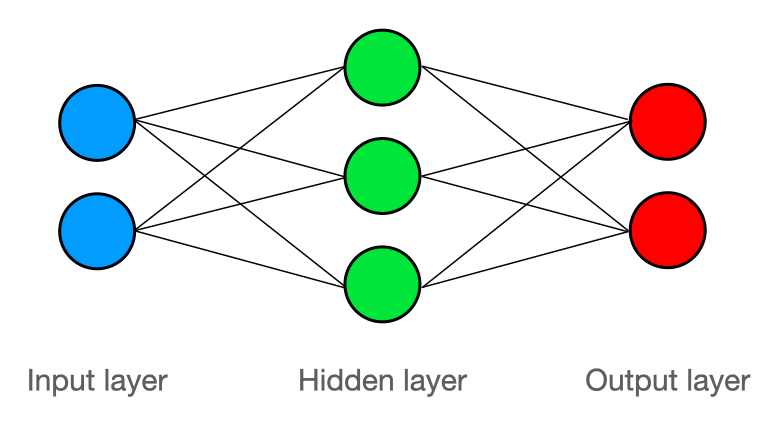

It consists of an input layer with two nodes because each sample consists of two features (score test 1 and score test 2). Then we have one hidden layer consisting of three nodes. Finally the output layer has two nodes corresponding to the two categories that need to be distinghuished.

The hidden layer has a **sigmoid** activation function while the outputlayer has a **softmax** activation function. 

### Define the activation functions

Below you define the required activation functions and their derivatives

In [5]:
# define some activation functions

def sigmoid(z):
    """
    returns the sigmoid function of z

    Parameters
    ----------
    z : float or ndarray

    Returns
    -------
    out : same type and shape as z

    """
    
    '''YOUR CODE GOES HERE '''
    #z = np.float64(z)  
    return 1 / (1 + np.exp(-z))


def sigmoid_diff(z):
    """
    returns the derivative of the sigmoid function of z

    Parameters
    ----------
    z : float or ndarray

    Returns
    -------
    out : same type and shape as z

    """
    
    '''YOUR CODE GOES HERE '''
    s = sigmoid(z)
    return s * (1-s)


def softmax(z):
    """
    returns the softmax function of z

    Parameters
    ----------
    z : 2D ndarray

    Returns
    -------
    out : same type and shape as z

    """
    
    '''YOUR CODE GOES HERE '''
    
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)



### Initalize the weights and biases
The layers are denoted with $l$. Our NN has an input layer ($l=0$), an output layer ($l=L=2$) and a hidden layer ($l=1$).

For each layer $l$ we have:
1. A number of nodes: $n_l$
2. A weight matrix: $\textbf W^{l} \in \mathbb{R}^{n_l \times n_{l-1}}$
3. A bias (column) vector: $\textbf b^{l} \in \mathbb{R}^{n_l \times 1}$

The input layer actually does not do much, it just passes the sample data to the output which then acts as input for the first hidden layer. So the input layer does not have a weight and bias.

The biases can be initialized with zeros; the weight's of layer $l$ are best intialized with random numbers from a normal distribution with mean 0 and standard deviation of $\sqrt{1/n_{l-1}}$. 

In [6]:
# intialize the neural network

# number of nodes in each layer
n0 = 2
n1 = 3
n2 = 2

# input layer
# no weights and biases

# hidden layer (l=1)
W1 = np.random.normal(scale=np.sqrt(1/n0), size=(n1,n0))
b1 = np.zeros((n1,1))

# output layer (l=2)
W2 = np.random.normal(scale=np.sqrt(1/n1), size=(n2,n1))
b2 = np.zeros((n2,1))

## 5. Train the NN

Firt you define three parameters that can be adjusted for optimal training.
- **learning_rate**: determines to what extend we update the weights and biases in the gradient descent step
- **no_epochs**: the number of times we pass the training data set through the network for training
- **batch_size**: how many samples we pass through the network before doing a gradient descent update

In [7]:
# train settings
learning_rate = 0.1
no_epochs = 1000
batch_size = 10

Below you implement the training of the network. A general layout (pseudocode) is already given. Note that we use the **Cross Entropy** (CE) loss function.

In [8]:
# perform the training
batch_size=16

# training_set = [
#     (X_train[i:i + batch_size], Y_train[i:i + batch_size]) 
#     for i in range(0, len(X_train), batch_size)
# ]
#print("tr",training_set)

train_losses = []
train_accuracies = []
m = X_train.shape[1]  
indices = np.arange(m)


def binary_crossentropy(Y, A):
    eps = 1e-15
    return -np.mean(np.sum(Y * np.log(A + eps) + (1 - Y) * np.log(1 - A + eps),
                           axis=0))  # sum over classes, then average over samples
    
def accuracy_score(Y, A):
    pred_labels = np.argmax(A, axis=0)
    true_labels = np.argmax(Y, axis=0)
    return np.mean(pred_labels == true_labels)
    
    
for epoch in range(1, no_epochs + 1):
    np.random.shuffle(indices)
    epoch_loss = 0.0
    epoch_correct = 0.0
    for start_col in range(0,m,batch_size):
        end_col = start_col + batch_size
        
        batch_idx = indices[start_col:end_col]
        
        X_batch = X_train[:, batch_idx] 
        Y_batch = Y_train[:, batch_idx]
        
        # forward pass
        # compute the output of the network for the batch
        z1 = W1 @ X_batch + b1
        a1 = sigmoid(z1)        
        z2 = W2 @ a1 + b2
        a2 = softmax(z2)  
        output_train = softmax(z2)
        
        # loss and accuracy
        batch_loss = binary_crossentropy(Y_batch, a2)
        batch_acc = accuracy_score(Y_batch, a2) 
        
        # accumulate the loss for average of entire epoch
        epoch_correct += batch_acc * X_batch.shape[1]
        epoch_loss += batch_loss * X_batch.shape[1]
        
        # backward pass
        # compute the derivatives dLdW and dLdb for the layers (use CE loss)
        dz2 = a2 - Y_batch  # shape (n2, batch_size)
        dW2 = (dz2 @ a1.T) / X_batch.shape[1]      
        db2 = np.sum(dz2, axis=1, keepdims=True) \
            / X_batch.shape[1]                   

        # hidden layer
        dz1 = (W2.T @ dz2) * sigmoid_diff(z1)       
        dW1 = (dz1 @ X_batch.T) / X_batch.shape[1] 
        db1 = np.sum(dz1, axis=1, keepdims=True) \
            / X_batch.shape[1]                  
        
        # gradient descent step / update weights and biases
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
    
    # for each epoch evaluate the network performance
    # compute accuracy of train set and store for later analysis
    epoch_loss /= m
    epoch_acc  = epoch_correct / m

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # for each epoch print info on learning progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{no_epochs} "
              f"Loss={epoch_loss:.4f}  Acc={epoch_acc:.4f}")


Epoch 100/1000 Loss=2.7749  Acc=0.8667
Epoch 200/1000 Loss=2.7826  Acc=0.8778
Epoch 300/1000 Loss=2.7851  Acc=0.8556
Epoch 400/1000 Loss=2.7864  Acc=0.8556
Epoch 500/1000 Loss=2.7868  Acc=0.8667
Epoch 600/1000 Loss=2.7873  Acc=0.8667
Epoch 700/1000 Loss=2.7877  Acc=0.8889
Epoch 800/1000 Loss=2.7879  Acc=0.8667
Epoch 900/1000 Loss=2.7882  Acc=0.8444
Epoch 1000/1000 Loss=2.7881  Acc=0.8889


## 6. Analyze the result
To analyze the result compute the losses and the accuracy of the test set. Also make a plot of the training loss and training accuracy as function of the epoch.

In [10]:
# compute the accuracy and losses of the test set
'''YOUR CODE GOES HERE '''
z1_test = W1 @ X_test + b1
a1_test = sigmoid(z1_test)
z2_test = W2 @ a1_test + b2
a2_test = softmax(z2_test)

test_loss=  binary_crossentropy(Y_test, a2_test)
test_acc = accuracy_score(Y_test, a2_test) 

print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 2.407126
Test Accuracy: 0.7000


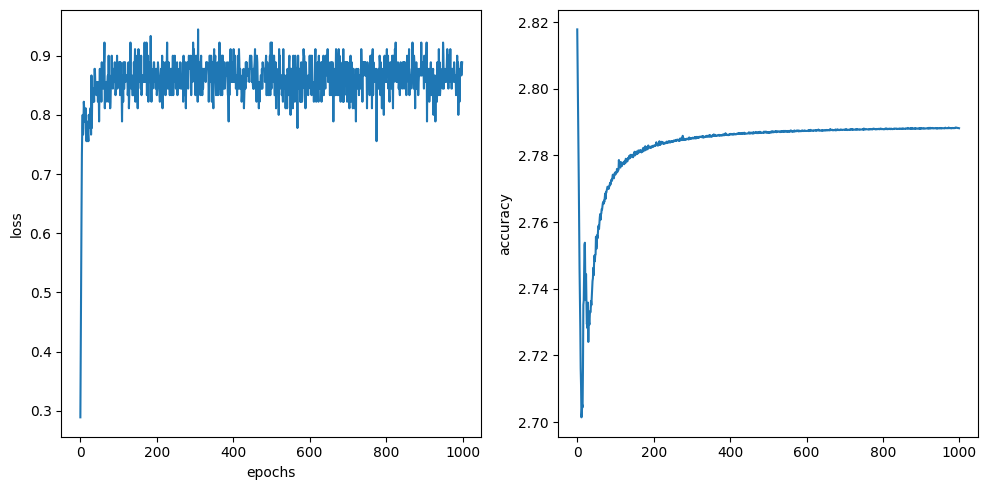

In [20]:
# plot the loss and accuracy as function of the epoch number
'''YOUR CODE GOES HERE '''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(train_accuracies)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')

ax2.plot(train_losses)
ax1.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

plt.tight_layout()
plt.show()
# plotdata(X1, y1, theta)

Below you find some code to plot the data and the model prediction. 

Text(0, 0.5, 'Normalized Score test 2')

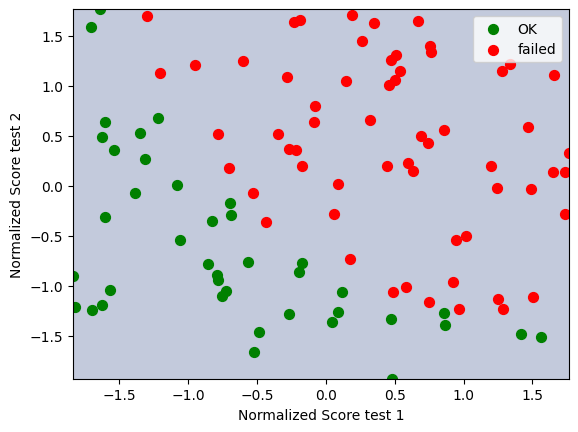

In [11]:
# visualize the results

# plot the model as a filled contour plot
# build mesh of gridpoints
x1_min, x1_max = X[0,:].min(), X[0,:].max()
x2_min, x2_max = X[1,:].min(), X[1,:].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# compute hypothesis on the meshgrid 
# first create a 2xM ndarray with the values of the scores on the mesh 
X_mesh = np.vstack((xx1.ravel(), xx2.ravel()))

# compute the output of the network
a1 = sigmoid(W1 @ X_mesh + b1)
a2 = softmax(W2 @ a1 + b2)
h = a2[0] # select either one of the two features
h = h.reshape(xx1.shape)

# plot the contour level(s)
levels = [0.0, 0.5, 1.0]
plt.contourf(xx1, xx2, h, levels, alpha=0.3)

# plot the data
mask = Y[0] == 1
plt.scatter(*X[:2, mask], s=50, c='g', marker='o', label='OK')
plt.scatter(*X[:2,~mask], s=50, c='r', marker='o', label='failed')
plt.legend()
plt.xlabel('Normalized Score test 1')
plt.ylabel('Normalized Score test 2')